In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mdtraj as md
from scipy.optimize import curve_fit
import sys
import seaborn as sns
import scipy
import gzip
import pickle

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 150,                   # medium resolution

    # Axes
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

def find_xtc_filenames(path_to_dir, suffix=".xtc"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

def find_PRE_filenames(path_to_dir, suffix=".dat"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix) and 'PRE' in filename]

# constants for PRE calculations
k = 1.23e16 # Å^6 s^-2
tau_t = 0.1e-9 # s
delay_hsqc = 0.010 # 10 ms
delay_hmqc = 0.01086 # 10.86 ms
r2h_hsqc = 10.0 # s-1

# function to calculate PRE rates from distances
def calc_gamma2(r3, r6, angular, wh: float, tau_c: float, tau_t: float):
    s_pre = np.power(r3, 2)/r6*angular
    wh = 2*np.pi*1e6*wh
    j = lambda w : s_pre*tau_c / (1+(w*tau_c)**2) + (1-s_pre)*tau_t / (1+(w*tau_t)**2)
    return k*r6*(4*j(0) + 3*j(wh))

# function to calculate PRE intensity ratios from rates
def calc_hsqc_I(avg_gamma2, delay, r2h):

    return np.exp(-delay * avg_gamma2) * ( r2h / (r2h + avg_gamma2))

# function to calculate PRE intensity ratios from rates for HMQC experiments
def calc_hmqc_I(avg_gamma2, delay, r2h, r2mq):

    return np.exp(-delay * avg_gamma2) * ( r2h / (r2h + avg_gamma2)) * ( r2mq / (r2mq + avg_gamma2)) 

# function to calculate RMSE for PREs
def RMSE_PRE(gen_arr, exp_arr):

    gen_arr = np.array(gen_arr)
    exp_arr = np.array(exp_arr)
    exp_arr = np.minimum(float(1.0), exp_arr) # do not penalise for experimental intensities above 1 (not physically possible)
    
    return np.sqrt(np.mean((gen_arr-exp_arr)**2))

def RMSE(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.sqrt(np.mean((actual - predicted)**2))


data_path = '../Ensemble_reweighting/'


/tmp/ipykernel_1386494/75339724.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  wh_vals = [float(info[info['Experiment']==dat[:-4]]['PRE_MHz']) for dat in datfiles]
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


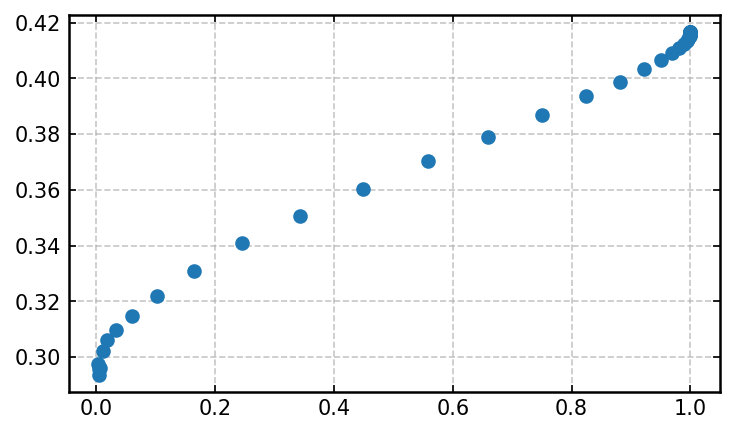

In [2]:
# analyse, cross-validation CS+SAXS reweighting
rew_dir = 'rest2_rew_cs_saxs/'

protein = 'ACTR_REST2_300K_ensemble'
tauc_values = np.arange(1,21,1)
tauc_values_ns = tauc_values*1e-9

# load reweighting data
wopt_array = np.load(data_path+rew_dir+f"rew_wopt_array.npy")
neffs = np.loadtxt(data_path+rew_dir+f"rew_neffs.txt")
relESS = []
for W in wopt_array:
    relESS.append((np.sum(W)**2/np.sum(W**2))/W.shape[0])


traj_names = np.sort(find_xtc_filenames(f'./{protein}/'))

# experimental information
datfiles = find_PRE_filenames(data_path+f'./exp_data_ACTR/')
sites = [int(dat.split('.')[0].split('-')[-1]) for dat in datfiles]
info = pd.read_csv(data_path+f'./exp_data_ACTR/info.csv')
wh_vals = [float(info[info['Experiment']==dat[:-4]]['PRE_MHz']) for dat in datfiles]


# initialise
exp_I = np.array([])
exp_res = np.array([])
all_r3 = np.array([])
all_r6 = np.array([])
all_angular = np.array([])
# load experimental data and pre-calculated (r3, r6, angular) simulation data
for dat, site, wh in zip(datfiles, sites, wh_vals):
    # experimental data
    try: 
        new_exp_res, new_exp_I = np.loadtxt(data_path+f"./exp_data_ACTR/{dat}", unpack=True)
    except:
        new_exp_res, new_exp_I, _ = np.loadtxt(data_path+f"./exp_data_ACTR/{dat}", unpack=True)
    mask = ~np.isnan(new_exp_I)
    new_exp_res, new_exp_I = new_exp_res[mask].astype(int), new_exp_I[mask]
    # simulation data
    sim_res, _, x = np.loadtxt(data_path+f"./{protein}/PRE/PRE-{traj_names[0][:-4]}-{site}.dat", unpack=True)
    sim_mask = ~np.isnan(_)
    sim_res = sim_res[sim_mask].astype(int)
    # find common residues
    common_residues = np.intersect1d(sim_res, new_exp_res)
    sim_idxs = np.array([list(sim_res).index(ele) for ele in common_residues])
    exp_idxs = np.array([list(new_exp_res).index(ele) for ele in common_residues])
    # append
    exp_I = np.concatenate((exp_I, new_exp_I[exp_idxs]), axis=0)
    exp_res = np.concatenate((exp_res, new_exp_res[exp_idxs]), axis=0)
    # all simulation data (pre-calculated)
    for traj in traj_names:
        with gzip.open(data_path+f"./{protein}/PRE/PRE-{traj[:-4]}-{site}.pkl", "rb") as f:
            simdata = pickle.load(f)
        tmp_r3, tmp_r6, tmp_angular = simdata['r3'], simdata['r6'], simdata['angular']
        try:
            r3 = np.concatenate((r3, tmp_r3[:, sim_idxs]), axis=0)
            r6 = np.concatenate((r6, tmp_r6[:, sim_idxs]), axis=0)
            angular = np.concatenate((angular, tmp_angular[:, sim_idxs]), axis=0)
        except:
            r3 = tmp_r3[:, sim_idxs]
            r6 = tmp_r6[:, sim_idxs]
            angular = tmp_angular[:, sim_idxs]
    # append to all sites data
    try:
        all_r3 = np.concatenate((all_r3, r3), axis=1)
        all_r6 = np.concatenate((all_r6, r6), axis=1)
        all_angular = np.concatenate((all_angular, angular), axis=1)
    except:
        all_r3 = r3
        all_r6 = r6
        all_angular = angular


# find frames where not all spin label positions could be fit and remove them
framesmask = ~np.isnan(all_r3).any(axis=1)
PRE_RMSEs = []
all_opt_tauc = []
for W in wopt_array:
    # calculate PRE intensities for all tauc values
    tauc_rmses = []
    tauc_sim_I = []
    for tauc in tauc_values_ns:
        gamma2 = calc_gamma2(r3=all_r3, r6=all_r6, angular=all_angular, wh=np.mean(wh_vals), tau_c=tauc, tau_t=tau_t)
        curr_sim_I = calc_hsqc_I(avg_gamma2=np.average(gamma2[framesmask], axis=0, weights=W[framesmask]), delay=delay_hsqc, r2h=r2h_hsqc)
        curr_rmse=RMSE_PRE(curr_sim_I, exp_I)
        tauc_rmses.append(curr_rmse)
        tauc_sim_I.append(curr_sim_I)
    # find optimal
    opt_rmse = np.min(tauc_rmses)
    opt_tauc = tauc_values[np.where(tauc_rmses==opt_rmse)[0][0]]
    sim_I = tauc_sim_I[np.where(tauc_rmses==opt_rmse)[0][0]]
    PRE_RMSEs.append(opt_rmse)
    all_opt_tauc.append(opt_tauc)

# save
np.savetxt(data_path+rew_dir+f"PRE_RMSEs.txt", PRE_RMSEs)

# plot
plt.figure(figsize = (5, 3))



plt.plot(neffs, PRE_RMSEs, 'o')

plt.tight_layout()
plt.show()

